# Régression polynômiale et pipeline

Le notebook compare plusieurs de modèles de régression polynômiale.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
data = load_wines_dataset()
X = data.drop(['quality', 'color'], axis=1)
y = data['quality']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

On normalise les données. Pour ce cas particulier, c'est d'autant plus important que les polynômes prendront de très grandes valeurs si cela n'est pas fait et les librairies de calculs n'aiment pas les ordres de grandeurs trop différents.

In [4]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)

La transformation [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) créée de nouvelles features en multipliant les variables les unes avec les autres. Pour le degré deux et trois features $a, b, c$, on obtient les nouvelles features : $1, a, b, c, a^2, ab, ac, b^2, bc, c^2$.

In [5]:
from time import perf_counter 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

r2ts = []
r2es = []
degs = []
tts = []
models = []

for d in range(1, 5):
    begin = perf_counter ()
    pipe = make_pipeline(PolynomialFeatures(degree=d), 
                         LinearRegression())
    pipe.fit(X_train_norm, y_train)
    duree = perf_counter () - begin
    r2t = r2_score(y_train, pipe.predict(X_train_norm))
    r2e = r2_score(y_test, pipe.predict(X_test_norm))
    degs.append(d)
    r2ts.append(r2t)
    r2es.append(r2e)
    tts.append(duree)
    models.append(pipe)
    print(d, r2t, r2e, duree)

1 0.189007413643138 0.17548948727814861 0.005909326000001158
2 0.3090044704138045 0.3016856760353912 0.027130041999996024
3 0.4065060987061494 -0.057880204420430736 0.22084438099999915
4 0.5874526458338967 -3659.6472584680923 2.230189553999999


In [6]:
import pandas
df = pandas.DataFrame(dict(temps=tts, r2_train=r2ts, r2_test=r2es, degré=degs))
df.set_index('degré')

,temps,r2_train,r2_test
degré,,,
1,0.005909,0.189007,0.175489
2,0.027130,0.309004,0.301686
3,0.220844,0.406506,-0.057880
4,2.230190,0.587453,-3659.647258


Le polynômes de degré 2 paraît le meilleur modèle. Le temps de calcul est multiplié par 10 à chaque fois, ce qui correspond au nombre de features. On voit néanmoins que l'ajout de features croisée fonctionne sur ce jeu de données. Mais au delà de 3, la régression produit des résultats très mauvais sur la base de test alors qu'ils continuent d'augmenter sur la base d'apprentissage. Voyons cela un peu plus en détail.

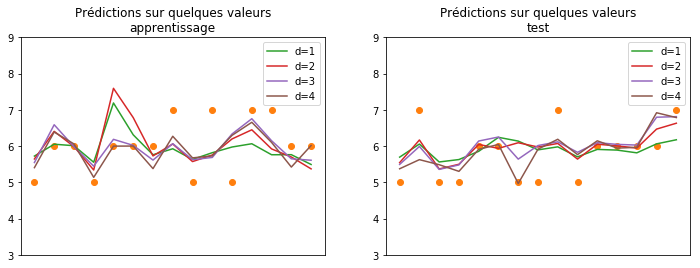

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

n = 15
ax[0].plot(y_train[:n].reset_index(), 'o')
ax[1].plot(y_test[:n].reset_index(), 'o')
ax[0].set_title('Prédictions sur quelques valeurs\napprentissage')
ax[1].set_title('Prédictions sur quelques valeurs\ntest')
for x in ax:
    x.set_ylim([3, 9])
    x.get_xaxis().set_visible(False)

for model in models:
    d = model.get_params()['polynomialfeatures__degree']
    tr = model.predict(X_train_norm[:n])
    te = model.predict(X_test_norm[:n])
    ax[0].plot(tr, label="d=%d" % d)
    ax[1].plot(te, label="d=%d" % d)
ax[0].legend()
ax[1].legend();

Le modèle de degré 4 a l'air performant sur la base d'apprentissage mais s'égare complètement sur la base de test comme s'il était surpris des valeurs rencontrées sur la base de test. On dit que le modèle fait du [sur-apprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) ou [overfitting](https://en.wikipedia.org/wiki/Overfitting) en anglais. Le polynôme de degré fonctionne mieux que la régression linéaire simple. On peut se demander quelles sont les variables croisées qui ont un impact sur la performance. On utilise le modèle [statsmodels](http://www.statsmodels.org/stable/index.html).

In [8]:
poly = PolynomialFeatures(degree=2)
poly_feat_train = poly.fit_transform(X_train_norm)
poly_feat_test = poly.fit_transform(X_test_norm)

In [9]:
from statsmodels.regression.linear_model import OLS
model = OLS(y_train, poly_feat_train)
results = model.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.302     
Dependent Variable: quality          AIC:                10821.7528
Date:               2018-09-09 14:59 BIC:                11321.5798
No. Observations:   4872             Log-Likelihood:     -5333.9   
Df Model:           76               F-statistic:        28.70     
Df Residuals:       4795             Prob (F-statistic): 0.00      
R-squared:          0.313            Scale:              0.53135   
-------------------------------------------------------------------
          Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-------------------------------------------------------------------
const   -1062.0749  1873.8933 -0.5668 0.5709  -4735.7657  2611.6159
x1         -2.0670    24.3092 -0.0850 0.9322    -49.7241    45.5901
x2       -729.2270   157.0307 -4.6439 0.0000  -1037.0792  -421.3748
x3          8.7231   200.5623  0.0435 0.9653   -384.4709   401.9171
x4          3.4131    13.3672  0.2553 0.7985    -22.7927    29.6188
x5      -1171.6645   689.5425 -1.6992 0.0893  -2523.4842   180.1551
x6         40.1316     8.1636  4.9159 0.0000     24.1272    56.1360
x7         70.8825    22.2599  3.1843 0.0015     27.2429   114.5221
x8       -724.4624   724.6583 -0.9997 0.3175  -2145.1251   696.2003
x9       -251.7727   192.4538 -1.3082 0.1909   -629.0704   125.5250
x10      -276.1104   163.5189 -1.6886 0.0914   -596.6824    44.4616
x11       258.8220    24.9389 10.3782 0.0000    209.9303   307.7138
x12      1021.3730  1866.5461  0.5472 0.5843  -2637.9138  4680.6598
x13       394.9815   155.7356  2.5362 0.0112     89.6682   700.2947
x14       250.5746   208.6039  1.2012 0.2297   -158.3848   659.5340
x15        -4.4734    21.4718 -0.2083 0.8350    -46.5681    37.6213
x16      -829.1409   537.0924 -1.5438 0.1227  -1882.0886   223.8067
x17        -7.9049     9.5287 -0.8296 0.4068    -26.5856    10.7758
x18         5.7595    21.3304  0.2700 0.7872    -36.0579    47.5770
x19       375.0969  1075.4182  0.3488 0.7273  -1733.2162  2483.4100
x20       114.3253   261.5978  0.4370 0.6621   -398.5264   627.1770
x21      -134.9056   151.9652 -0.8877 0.3747   -432.8272   163.0159
x22       -72.6985    26.4607 -2.7474 0.0060   -124.5735   -20.8234
x23       520.0041  1956.5000  0.2658 0.7904  -3315.6336  4355.6418
x24      -325.9049  1598.8675 -0.2038 0.8385  -3460.4188  2808.6090
x25      -231.1519   129.0113 -1.7917 0.0732   -484.0732    21.7694
x26      4345.4355  4193.6897  1.0362 0.3002  -3876.1206 12566.9917
x27       169.8998    63.4267  2.6787 0.0074     45.5543   294.2453
x28       542.4856   138.8860  3.9060 0.0001    270.2053   814.7658
x29     -8778.6169  5436.2565 -1.6148 0.1064 -19436.1739  1878.9402
x30      1809.6247  1561.8380  1.1587 0.2467  -1252.2945  4871.5438
x31     -2415.5578  1236.4205 -1.9537 0.0508  -4839.5094     8.3938
x32       749.0360   191.8871  3.9035 0.0001    372.8492  1125.2228
x33      -566.9825  2058.9378 -0.2754 0.7830  -4603.4454  3469.4803
x34      -107.1104   167.6736 -0.6388 0.5230   -435.8275   221.6068
x35      3906.7743  5806.8281  0.6728 0.5011  -7477.2732 15290.8218
x36        10.0617    81.2204  0.1239 0.9014   -149.1677   169.2910
x37       -24.5923   177.8119 -0.1383 0.8900   -373.1851   324.0006
x38       743.3110  8266.7074  0.0899 0.9284 -15463.2288 16949.8507
x39     -2927.3589  2162.4656 -1.3537 0.1759  -7166.7837  1312.0660
x40      1943.9211  1604.4419  1.2116 0.2257  -1201.5212  5089.3633
x41       604.3677   250.6121  2.4116 0.0159    113.0530  1095.6823
x42      1020.5273  1873.8778  0.5446 0.5860  -2653.1330  4694.1876
x43      1250.7078   760.6158  1.6443 0.1002   -240.4481  2741.8637
x44       -10.1449     4.8977 -2.0714 0.0384    -19.7466    -0.5432
x45         2.2443    12.2455  0.1833 0.8546    -21.7624    26.2511
x46       616.4495   725.

Ce n'est pas très lisible. Il faut ajouter le nom de chaque variable et recommencer.

In [10]:
names = poly.get_feature_names(input_features=data.columns[:-2])
names = [n.replace(" ", " * ") for n in names]
pft = pandas.DataFrame(poly_feat_train, columns=names)
pft.head()

,1,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,...,density^2,density * pH,density * sulphates,density * alcohol,pH^2,pH * sulphates,pH * alcohol,sulphates^2,sulphates * alcohol,alcohol^2
0,1.0,0.034535,0.001889,0.002752,0.042089,0.000297,0.285993,0.955108,0.005369,0.016836,...,0.000029,0.000090,0.000013,0.000278,0.000283,0.000041,0.000872,0.000006,0.000126,0.002683
1,1.0,0.056514,0.002868,0.003627,0.013496,0.000346,0.244614,0.961585,0.008352,0.027245,...,0.000070,0.000228,0.000031,0.000888,0.000742,0.000101,0.002896,0.000014,0.000394,0.011296
2,1.0,0.062938,0.001033,0.002442,0.139027,0.000498,0.413325,0.892406,0.009363,0.030060,...,0.000088,0.000281,0.000031,0.000862,0.000904,0.000099,0.002767,0.000011,0.000303,0.008475
3,1.0,0.120882,0.004638,0.005622,0.036546,0.001167,0.224896,0.955808,0.014025,0.046385,...,0.000197,0.000651,0.000095,0.001853,0.002152,0.000313,0.006129,0.000046,0.000891,0.017457
4,1.0,0.455253,0.018602,0.023497,0.186017,0.006462,0.146856,0.538471,0.048745,0.158115,...,0.002376,0.007707,0.001360,0.031497,0.025000,0.004412,0.102168,0.000779,0.018030,0.417530


In [11]:
results.summary2(xname=pft.columns)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Ordinary least squares
======================================================================================================
Model:                           OLS                         Adj. R-squared:                0.302     
Dependent Variable:              quality                     AIC:                           10821.7528
Date:                            2018-09-09 15:02            BIC:                           11321.5798
No. Observations:                4872                        Log-Likelihood:                -5333.9   
Df Model:                        76                          F-statistic:                   28.70     
Df Residuals:                    4795                        Prob (F-statistic):            0.00      
R-squared:                       0.313                       Scale:                         0.53135   
------------------------------------------------------------------------------------------------------
                                             Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
------------------------------------------------------------------------------------------------------
1                                          -1062.0749  1873.8933 -0.5668 0.5709  -4735.7657  2611.6159
fixed_acidity                                 -2.0670    24.3092 -0.0850 0.9322    -49.7241    45.5901
volatile_acidity                            -729.2270   157.0307 -4.6439 0.0000  -1037.0792  -421.3748
citric_acid                                    8.7231   200.5623  0.0435 0.9653   -384.4709   401.9171
residual_sugar                                 3.4131    13.3672  0.2553 0.7985    -22.7927    29.6188
chlorides                                  -1171.6645   689.5425 -1.6992 0.0893  -2523.4842   180.1551
free_sulfur_dioxide                           40.1316     8.1636  4.9159 0.0000     24.1272    56.1360
total_sulfur_dioxide                          70.8825    22.2599  3.1843 0.0015     27.2429   114.5221
density                                     -724.4624   724.6583 -0.9997 0.3175  -2145.1251   696.2003
pH                                          -251.7727   192.4538 -1.3082 0.1909   -629.0704   125.5250
sulphates                                   -276.1104   163.5189 -1.6886 0.0914   -596.6824    44.4616
alcohol                                      258.8220    24.9389 10.3782 0.0000    209.9303   307.7138
fixed_acidity^2                             1021.3730  1866.5461  0.5472 0.5843  -2637.9138  4680.6598
fixed_acidity * volatile_acidity             394.9815   155.7356  2.5362 0.0112     89.6682   700.2947
fixed_acidity * citric_acid                  250.5746   208.6039  1.2012 0.2297   -158.3848   659.5340
fixed_acidity * residual_sugar                -4.4734    21.4718 -0.2083 0.8350    -46.5681    37.6213
fixed_acidity * chlorides                   -829.1409   537.0924 -1.5438 0.1227  -1882.0886   223.8067
fixed_acidity * free_sulfur_dioxide           -7.9049     9.5287 -0.8296 0.4068    -26.5856    10.7758
fixed_acidity * total_sulfur_dioxide           5.7595    21.3304  0.2700 0.7872    -36.0579    47.5770
fixed_acidity * density                      375.0969  1075.4182  0.3488 0.7273  -1733.2162  2483.4100
fixed_acidity * pH                           114.3253   261.5978  0.4370 0.6621   -398.5264   627.1770
fixed_acidity * sulphates                   -134.9056   151.9652 -0.8877 0.3747   -432.8272   163.0159
fixed_acidity * alcohol                      -72.6985    26.4607 -2.7474 0.0060   -124.5735   -20.8234
volatile_acidity^2                           520.0041  1956.5000  0.2658 0.7904  -3315.6336  4355.6418
volatile_acidity * citric_acid              -325.9049  1598.8675 -0.2038 0.8385  -3460.4188  2808.6090
volatile_acidity * residual_sugar           -231.1519   129.0113 -1.7917 0.0732   -484.0732    21.7694
volatile_acidity * chlorides                4345.4355  4193.6897  1.0362 

On ne garde que celles dont la [p-value](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/c_metric/pvalues.html) est inférieur à 0.05.

In [12]:
pval = results.pvalues.copy()
pval[pval <= 0.05]

x2     3.511159e-06
x6     9.131393e-07
x7     1.460269e-03
x11    5.715290e-25
x13    1.123675e-02
x22    6.029122e-03
x27    7.416579e-03
x28    9.513630e-05
x32    9.610320e-05
x41    1.592150e-02
x44    3.837865e-02
x58    1.505845e-05
x62    5.085920e-10
x66    4.296131e-02
x67    4.014502e-18
x71    2.520870e-02
x72    4.211861e-02
x74    4.190811e-03
x76    4.648129e-02
dtype: float64

In [13]:
pval.index = pft.columns
pval[pval <= 0.05]

volatile_acidity                              3.511159e-06
free_sulfur_dioxide                           9.131393e-07
total_sulfur_dioxide                          1.460269e-03
alcohol                                       5.715290e-25
fixed_acidity * volatile_acidity              1.123675e-02
fixed_acidity * alcohol                       6.029122e-03
volatile_acidity * free_sulfur_dioxide        7.416579e-03
volatile_acidity * total_sulfur_dioxide       9.513630e-05
volatile_acidity * alcohol                    9.610320e-05
citric_acid * alcohol                         1.592150e-02
residual_sugar * free_sulfur_dioxide          3.837865e-02
free_sulfur_dioxide * total_sulfur_dioxide    1.505845e-05
free_sulfur_dioxide * alcohol                 5.085920e-10
total_sulfur_dioxide * sulphates              4.296131e-02
total_sulfur_dioxide * alcohol                4.014502e-18
density * alcohol                             2.520870e-02
pH^2                                          4.211861e-

Le modèle fonctionne mieux mais il est plus compliqué de savoir si la contribution de l'alcool est corrélée positivement avec la qualité car l'alcool apparaît dans plus d'une variable.